Train size: 480
Validation size: 160
Test size: 160
Training model with C = 0.01
Training model with C = 0.1
Training model with C = 1.0
Training model with C = 10.0
Training model with C = 100.0

C | Val acc | Val F1 | Log loss | ||w||
-------------------------------------------
0.01  | 0.9000 | 0.9048 | 0.4263 | 0.9307
0.1   | 0.9000 | 0.9036 | 0.2798 | 2.3216
1.0   | 0.9000 | 0.9024 | 0.2542 | 3.4183
10.0  | 0.9000 | 0.9024 | 0.2534 | 3.7118
100.0 | 0.9000 | 0.9024 | 0.2534 | 3.7479

Best C based on validation macro F1: 0.01

Test performance:
Accuracy   : 0.9250
Macro F1   : 0.9241
Log loss   : 0.4070

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93        80
           1       0.94      0.91      0.92        80

    accuracy                           0.93       160
   macro avg       0.93      0.93      0.92       160
weighted avg       0.93      0.93      0.92       160

Confusion matrix:
[[75  5]
 [ 7 73]]

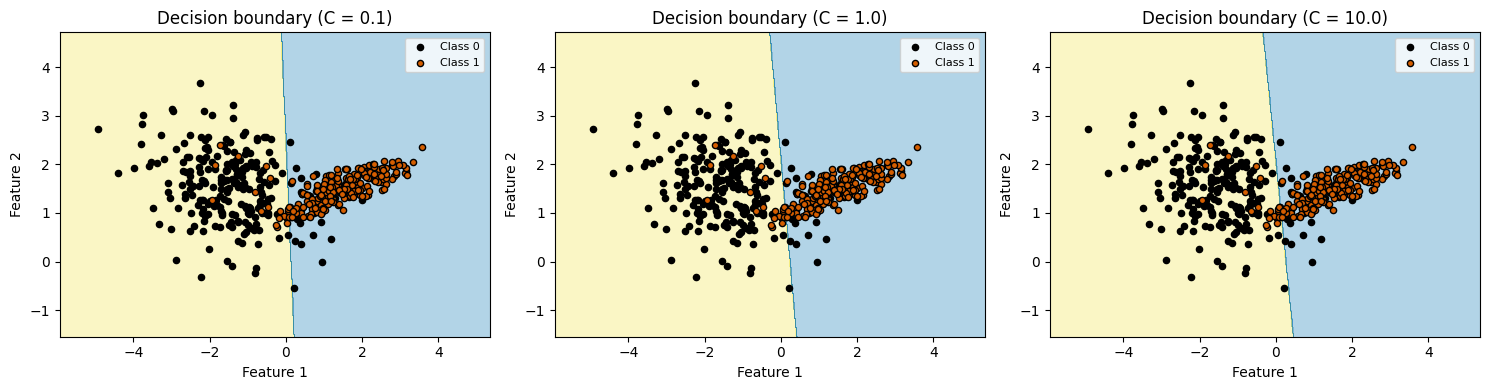

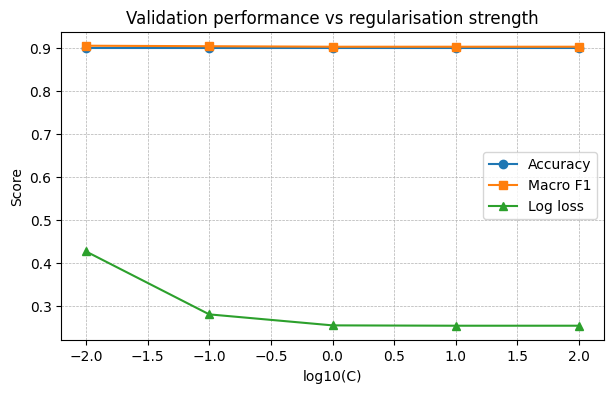

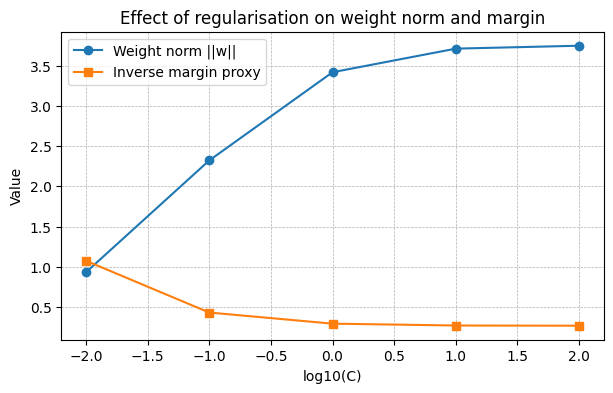

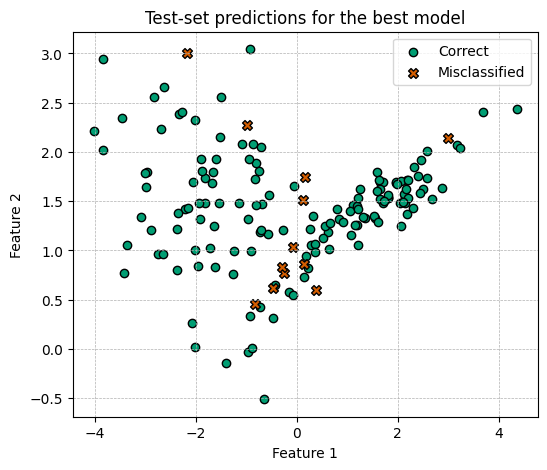

In [2]:
# Logistic Regression – Effect of L2 Regularisation on Decision Geometry
# Single-cell, Word/report-friendly (NO figure numbers in plots)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report

# ------------------------------------------------------
# 1. Dataset generation
# ------------------------------------------------------
RANDOM_STATE = 42

X, y = make_classification(
    n_samples=800,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=1.5,
    flip_y=0.05,
    random_state=RANDOM_STATE
)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=RANDOM_STATE
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

# ------------------------------------------------------
# 2. Regularisation strengths
# ------------------------------------------------------
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
results = []

def build_model(C):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            penalty="l2",
            C=C,
            max_iter=1000,
            solver="lbfgs",
            random_state=RANDOM_STATE
        ))
    ])

# ------------------------------------------------------
# 3. Training and validation
# ------------------------------------------------------
for C in C_values:
    print(f"Training model with C = {C}")
    model = build_model(C)
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    y_val_prob = model.predict_proba(X_val)

    acc = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    loss = log_loss(y_val, y_val_prob)

    w = model.named_steps["logreg"].coef_[0]
    w_norm = np.linalg.norm(w)
    margin = 1.0 / w_norm

    results.append((C, acc, f1, loss, w_norm, margin, model))

print("\nC | Val acc | Val F1 | Log loss | ||w||")
print("-------------------------------------------")
for r in results:
    print(f"{r[0]:<5} | {r[1]:.4f} | {r[2]:.4f} | {r[3]:.4f} | {r[4]:.4f}")

best_model = max(results, key=lambda x: x[2])
best_C = best_model[0]
clf_best = best_model[6]

print(f"\nBest C based on validation macro F1: {best_C}")

# ------------------------------------------------------
# 4. Test evaluation
# ------------------------------------------------------
y_test_pred = clf_best.predict(X_test)
y_test_prob = clf_best.predict_proba(X_test)

print("\nTest performance:")
print(f"Accuracy   : {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Macro F1   : {f1_score(y_test, y_test_pred):.4f}")
print(f"Log loss   : {log_loss(y_test, y_test_prob):.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_test_pred))

# ------------------------------------------------------
# 5. Decision boundary plots (NO figure numbers)
# ------------------------------------------------------
bg_cmap = ListedColormap(["#f0e442", "#0072b2"])
pt_colors = ["#000000", "#d55e00"]

def plot_boundary(ax, model, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=bg_cmap, alpha=0.3)
    for cls in np.unique(y):
        ax.scatter(X_train[y_train == cls, 0],
                   X_train[y_train == cls, 1],
                   c=pt_colors[cls],
                   edgecolor="k",
                   s=20,
                   label=f"Class {cls}")
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.legend(fontsize=8)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, C in zip(axes, [0.1, 1.0, 10.0]):
    model = [r for r in results if r[0] == C][0][6]
    plot_boundary(ax, model, f"Decision boundary (C = {C})")

plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 6. Metric trends
# ------------------------------------------------------
Cs = np.array([r[0] for r in results])
accs = np.array([r[1] for r in results])
f1s = np.array([r[2] for r in results])
losses = np.array([r[3] for r in results])
norms = np.array([r[4] for r in results])
margins = np.array([r[5] for r in results])

logCs = np.log10(Cs)

plt.figure(figsize=(7, 4))
plt.plot(logCs, accs, marker="o", label="Accuracy")
plt.plot(logCs, f1s, marker="s", label="Macro F1")
plt.plot(logCs, losses, marker="^", label="Log loss")
plt.xlabel("log10(C)")
plt.ylabel("Score")
plt.title("Validation performance vs regularisation strength")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(logCs, norms, marker="o", label="Weight norm ||w||")
plt.plot(logCs, margins, marker="s", label="Inverse margin proxy")
plt.xlabel("log10(C)")
plt.ylabel("Value")
plt.title("Effect of regularisation on weight norm and margin")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# ------------------------------------------------------
# 7. Correct vs incorrect test samples
# ------------------------------------------------------
correct = (y_test_pred == y_test)

plt.figure(figsize=(6, 5))
plt.scatter(X_test[correct, 0], X_test[correct, 1],
            c="#009e73", edgecolor="k", label="Correct")
plt.scatter(X_test[~correct, 0], X_test[~correct, 1],
            c="#d55e00", marker="X", s=50, edgecolor="k",
            label="Misclassified")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Test-set predictions for the best model")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()
